<a href="https://colab.research.google.com/github/nguyenduytung74913/bai-tap-ve-nha-deep-learning/blob/main/bai2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow==2.3.1


     |████████████████████████████████| 320.4MB 46kB/s 


In [ ]:
!pip install -q tensorflow-quantum

     |████████████████████████████████| 5.9MB 4.4MB/s 
     |████████████████████████████████| 1.6MB 43.4MB/s 
     |████████████████████████████████| 5.6MB 43.0MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11493376/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


In [ ]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [ ]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


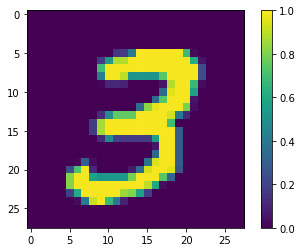

In [ ]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [ ]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

True


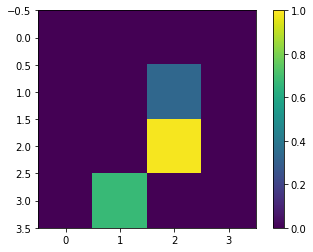

In [ ]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [ ]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(list(labels)[0])
      else:
          # Throw out images that match more than one label.
          pass
    
    num_3 = sum(1 for value in mapping.values() if True in value)
    num_6 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [ ]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of 3s:  4961
Number of 6s:  5475
Number of contradictory images:  49

Initial number of examples:  12049
Remaining non-contradictory examples:  11520


In [ ]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [ ]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of 3s:  124
Number of 6s:  113
Number of contradictory images:  44

Initial number of examples:  11520
Remaining non-contradictory examples:  3731


In [ ]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


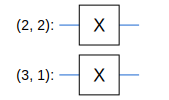

In [ ]:
SVGCircuit(x_train_circ[0])

In [ ]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

In [ ]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [ ]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [ ]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

62/62 [==============================] - 1s 22ms/step - loss: 0.0041 - accuracy: 0.9990


In [ ]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/20
90/90 - 0s - loss: 0.6965 - accuracy: 0.5027 - val_loss: 0.6732 - val_accuracy: 0.4868
Epoch 2/20
90/90 - 0s - loss: 0.6620 - accuracy: 0.5043 - val_loss: 0.6296 - val_accuracy: 0.5010
Epoch 3/20
90/90 - 0s - loss: 0.6154 - accuracy: 0.5698 - val_loss: 0.5709 - val_accuracy: 0.5894
Epoch 4/20
90/90 - 0s - loss: 0.5614 - accuracy: 0.7328 - val_loss: 0.5134 - val_accuracy: 0.7825
Epoch 5/20
90/90 - 0s - loss: 0.4861 - accuracy: 0.8357 - val_loss: 0.4298 - val_accuracy: 0.8049
Epoch 6/20
90/90 - 0s - loss: 0.4020 - accuracy: 0.8408 - val_loss: 0.3661 - val_accuracy: 0.8145
Epoch 7/20
90/90 - 0s - loss: 0.3451 - accuracy: 0.8485 - val_loss: 0.3224 - val_accuracy: 0.8166
Epoch 8/20
90/90 - 0s - loss: 0.3062 - accuracy: 0.8503 - val_loss: 0.2923 - val_accuracy: 0.8176
Epoch 9/20
90/90 - 0s - loss: 0.2789 - accuracy: 0.8514 - val_loss: 0.2714 - val_accuracy: 0.8176
Epoch 10/20
90/90 - 0s - loss: 0.2594 - accuracy: 0.8584 - val_loss: 0.2561 - val_accuracy: 0.8354
Epoch 11/20
90/90 -

In [ ]:
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D

from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical


In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_train[0].shape, 'image shape')

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples
(28, 28) image shape


In [ ]:
x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_train[0].shape, 'image shape')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
(28, 28, 1) image shape


In [ ]:
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [ ]:


class LeNet(Sequential):
    def __init__(self, input_shape, nb_classes):
        super().__init__()

        self.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=input_shape, padding="same"))
        self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
        self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Flatten())
        self.add(Dense(120, activation='tanh'))
        self.add(Dense(84, activation='tanh'))
        self.add(Dense(nb_classes, activation='softmax'))

        self.compile(optimizer='adam',
                    loss=categorical_crossentropy,
                    metrics=['accuracy'])

In [ ]:
model = LeNet(x_train[0].shape, num_classes)

In [ ]:
model.summary()

Model: "le_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_5 (Dense)              (None, 84)                10164

In [ ]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Specify the callback object
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model.fit(x_train, y=y_train, 
          epochs=20, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback],
          verbose=0)

In [ ]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.
